In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Data Preparation

In [6]:
data_directory = '../input/flowers-recognition/flowers'

image_size = 150

In [7]:
from tqdm import tqdm

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def process_images(directory, img_size=image_size):
    images = []
    labels = []

    for category in os.listdir(directory):
        sub_directory = os.path.join(directory, category)

        for i in tqdm(os.listdir(sub_directory)):
            path = os.path.join(sub_directory,i)
            img = cv2.imread(path)
            img = crop_center_square(img)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

            images.append(np.array(img))
            labels.append(str(category))
            
    return images, labels

In [8]:
images = []
labels = []

images, labels = process_images(data_directory, img_size=image_size)

print("Total number of train images processed: {}".format(len(images)))

100%|██████████| 784/784 [00:07<00:00, 108.88it/s]

Total number of train images processed: 4317


In [9]:
data = np.array(images)
labels = np.array(labels)

print('Input(Feature) Data shape :', data.shape)
print('Output(Labels) Data shape :', labels.shape)

Input(Feature) Data shape : (4317, 150, 150, 3)
Output(Labels) Data shape : (4317,)


# Visualise image samples

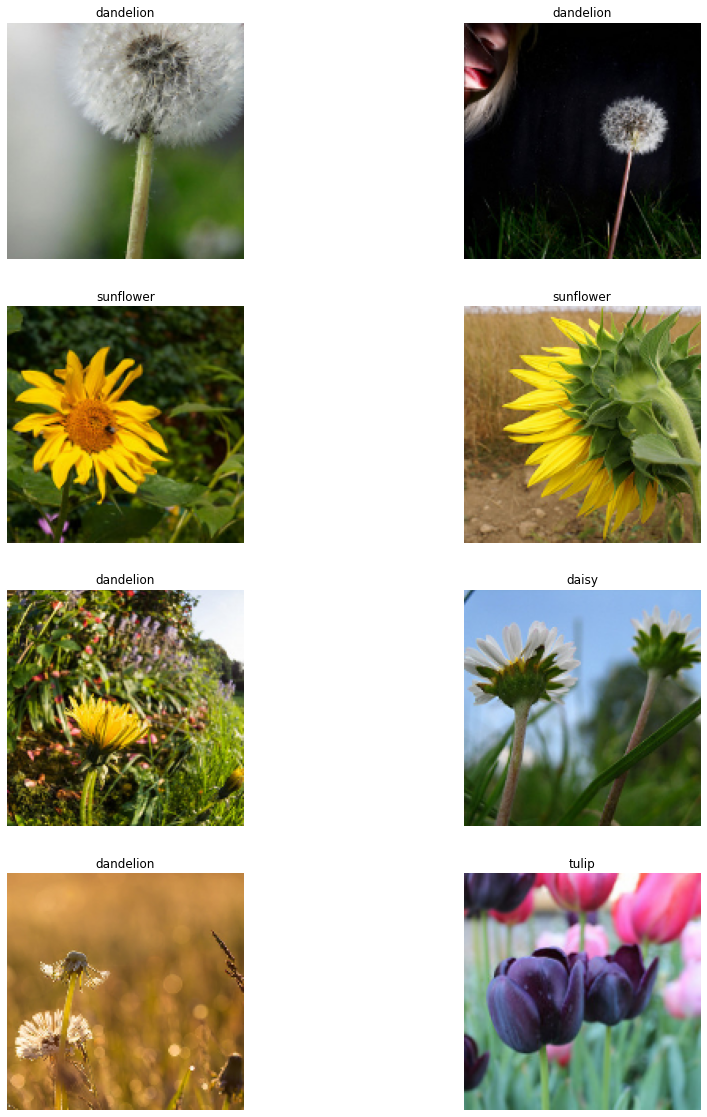

In [10]:
import random

fig, ax = plt.subplots(4, 2, figsize = (15, 20))
for i in range(4):
    for j in range(2):
        l = random.randint(0, data.shape[0])
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(labels[l])
        ax[i,j].axis('off')

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y, 5)
print(y)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [12]:
from sklearn.model_selection import train_test_split

# Normalize the input data in range [0 1]
X = data/255

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 5)

print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :" ,X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (3453, 150, 150, 3)
y_train shape : (3453, 5)
X_test shape : (864, 150, 150, 3)
y_test shape : (864, 5)


# Preparing Model: InceptionV3

In [13]:
from keras import models
from keras import layers
from keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [14]:
base_model = InceptionV3(input_shape = (image_size, image_size, 3), 
                         include_top = False, 
                         weights = 'imagenet')

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(5,activation="softmax"))
model.summary()

2022-05-03 09:41:25.539286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 09:41:25.652258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 09:41:25.653054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 09:41:25.654266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 22,328,613
Trainable params: 525,829
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [16]:
from keras.callbacks import ReduceLROnPlateau

red_lr = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.1,
                           epsilon=0.0001,
                           patience=2,
                           verbose=1)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center= False,
                              samplewise_center= False,
                              featurewise_std_normalization= False,
                              samplewise_std_normalization=False,
                              rotation_range= 10,     # 0-180
                              zca_whitening=False,
                              zoom_range=0.1,         # Randomly zoom image
                              width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True,   # randomly flip images
                              vertical_flip=False)    # randomly flip images
                             
datagen.fit(X_train)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger

batch_size = 32
nb_epochs = 10
weight_file = 'inceptionv3_model.h5'
history_file ='history.csv'

best_checkpoint = ModelCheckpoint(weight_file,
                                  save_weights_only=False, 
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=1)

history_logger = CSVLogger(history_file, separator=",", append=True)

History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = nb_epochs, 
                              validation_data = (X_test,y_test),
                              verbose = 1,
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[best_checkpoint, history_logger, red_lr])

Epoch 1/10
107/107 [==============================] - 20s 183ms/step - loss: 0.6379 - accuracy: 0.7641 - val_loss: 0.5839 - val_accuracy: 0.7928

Epoch 00001: val_accuracy improved from -inf to 0.79282, saving model to inceptionv3_model.h5
Epoch 2/10
107/107 [==============================] - 18s 172ms/step - loss: 0.5532 - accuracy: 0.8004 - val_loss: 0.5479 - val_accuracy: 0.8067

Epoch 00002: val_accuracy improved from 0.79282 to 0.80671, saving model to inceptionv3_model.h5
Epoch 3/10
107/107 [==============================] - 19s 176ms/step - loss: 0.5146 - accuracy: 0.8167 - val_loss: 0.5148 - val_accuracy: 0.8322

Epoch 00003: val_accuracy improved from 0.80671 to 0.83218, saving model to inceptionv3_model.h5
Epoch 4/10
107/107 [==============================] - 17s 160ms/step - loss: 0.4599 - accuracy: 0.8343 - val_loss: 0.4984 - val_accuracy: 0.8368

Epoch 00004: val_accuracy improved from 0.83218 to 0.83681, saving model to inceptionv3_model.h5
Epoch 5/10
107/107 [===========

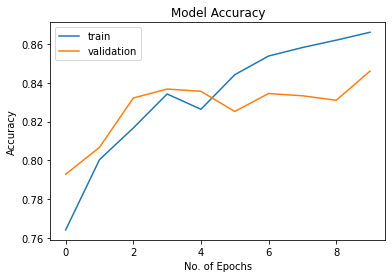

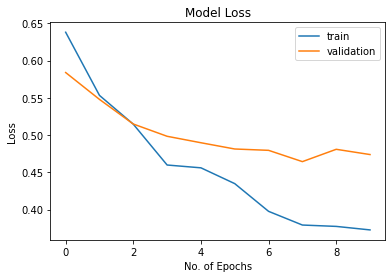

In [24]:
plt.plot(History.epoch, History.history['accuracy'])
plt.plot(History.epoch, History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['train', 'validation'])
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(History.epoch, History.history['loss'])
plt.plot(History.epoch, History.history['val_loss'])
plt.title('Model Loss')
plt.legend(['train', 'validation'])
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.show()

In [28]:
from sklearn.metrics import classification_report

preds = model.predict(X_test, batch_size=32)

report = classification_report(y_test.argmax(axis=1), 
                               preds.argmax(axis=1),
                               target_names=le.classes_)

print(report)

              precision    recall  f1-score   support

       daisy       0.90      0.84      0.86       153
   dandelion       0.83      0.96      0.89       203
        rose       0.80      0.82      0.81       169
   sunflower       0.88      0.80      0.84       142
       tulip       0.85      0.80      0.82       197

    accuracy                           0.85       864
   macro avg       0.85      0.84      0.84       864
weighted avg       0.85      0.85      0.85       864



In [29]:
metric = tf.keras.metrics.Accuracy()
metric.update_state(y_test.argmax(axis=1), preds.argmax(axis=1))
print("Percentage accuracy: {:.3f}%".format(metric.result().numpy()*100))

Percentage accuracy: 84.606%


<Figure size 432x288 with 0 Axes>

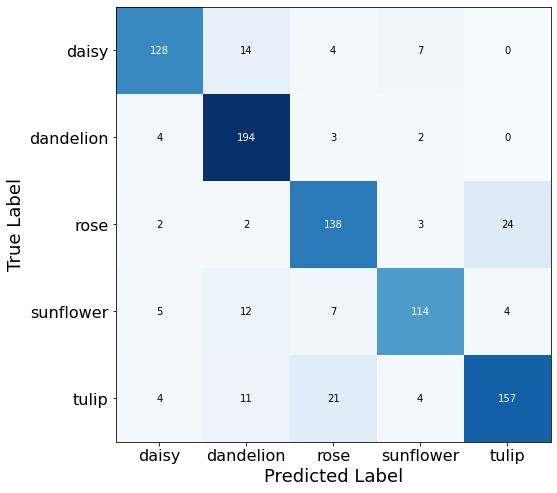

In [30]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1),)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(le.classes_)), le.classes_, fontsize=16)
plt.yticks(range(len(le.classes_)), le.classes_, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

# Fine Tuning InceptionV3

In [31]:
base_model.trainable = True

# freeze all layers except last 15
for layer in base_model.layers[:-15]:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(5,activation="softmax"))
model.summary()

# Recompile the model
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 22,328,613
Trainable params: 920,709
Non-trainable params: 21,407,904
_________________________________________________________________


In [32]:
History_fine_tune = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                                        epochs = 15, 
                                        validation_data = (X_test,y_test),
                                        verbose = 1,
                                        steps_per_epoch=X_train.shape[0] // batch_size,
                                        callbacks=[best_checkpoint, history_logger, red_lr],
                                        initial_epoch=History.epoch[-1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 10/15
107/107 [==============================] - 23s 185ms/step - loss: 0.8524 - accuracy: 0.6618 - val_loss: 0.5792 - val_accuracy: 0.7882

Epoch 00010: val_accuracy did not improve from 0.84606
Epoch 11/15
107/107 [==============================] - 18s 165ms/step - loss: 0.5377 - accuracy: 0.8088 - val_loss: 0.5125 - val_accuracy: 0.8183

Epoch 00011: val_accuracy did not improve from 0.84606
Epoch 12/15
107/107 [==============================] - 18s 168ms/step - loss: 0.4674 - accuracy: 0.8348 - val_loss: 0.4479 - val_accuracy: 0.8519

Epoch 00012: val_accuracy improved from 0.84606 to 0.85185, saving model to inceptionv3_model.h5
Epoch 13/15
107/107 [==============================] - 17s 162ms/step - loss: 0.4051 - accuracy: 0.8562 - val_loss: 0.4312 - val_accuracy: 0.8600

Epoch 00013: val_accuracy improved from 0.85185 to 0.85995, saving model to inceptionv3_model.h5
Epoch 14/15
107/107 [==============================] - 18s 166ms/step - loss: 0.3632 - accuracy: 0.8708 - va

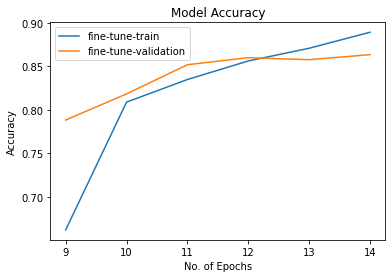

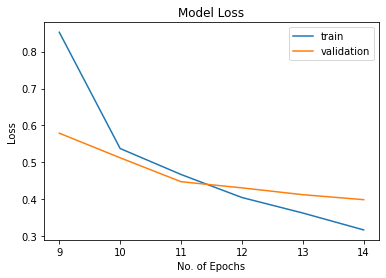

In [36]:
plt.plot(History_fine_tune.epoch, History_fine_tune.history['accuracy'])
plt.plot(History_fine_tune.epoch, History_fine_tune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['fine-tune-train', 'fine-tune-validation'])
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(History_fine_tune.epoch, History_fine_tune.history['loss'])
plt.plot(History_fine_tune.epoch, History_fine_tune.history['val_loss'])
plt.title('Model Loss')
plt.legend(['train', 'validation'])
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.show()

In [37]:
from sklearn.metrics import classification_report

preds = model.predict(X_test, batch_size=32)

report = classification_report(y_test.argmax(axis=1), 
                               preds.argmax(axis=1),
                               target_names=le.classes_)

print(report)

              precision    recall  f1-score   support

       daisy       0.89      0.88      0.88       153
   dandelion       0.91      0.91      0.91       203
        rose       0.84      0.79      0.82       169
   sunflower       0.83      0.89      0.86       142
       tulip       0.83      0.85      0.84       197

    accuracy                           0.86       864
   macro avg       0.86      0.86      0.86       864
weighted avg       0.86      0.86      0.86       864



In [38]:
metric = tf.keras.metrics.Accuracy()
metric.update_state(y_test.argmax(axis=1), preds.argmax(axis=1))
print("Percentage accuracy: {:.3f}%".format(metric.result().numpy()*100))

Percentage accuracy: 86.343%


<Figure size 432x288 with 0 Axes>

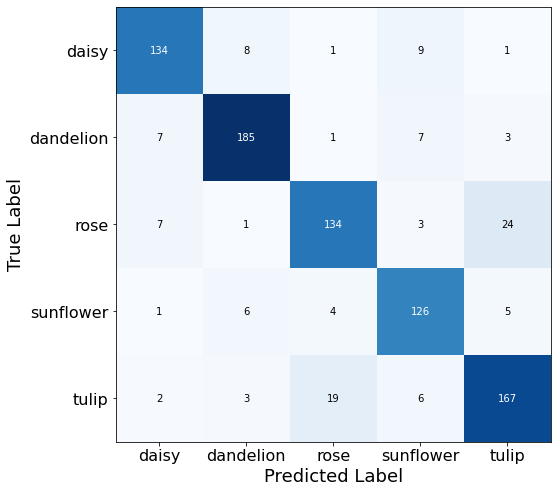

In [39]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1),)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(le.classes_)), le.classes_, fontsize=16)
plt.yticks(range(len(le.classes_)), le.classes_, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

# Image Inference

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import optimizers
from keras.models import load_model

In [ ]:
model = load_model('./inceptionv3_model.h5')

model.compile(optimizer=optimizers.Adam(learning_rate = 1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

filename = '../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg'

image = load_img(filename, target_size=(150, 150))
plt.imshow(image)
plt.show()

In [ ]:
import cv2
import numpy as np
import time

image_size = 150 

img = cv2.imread(filename)
img = cv2.resize(img,(image_size,image_size))
img = img/255
img = np.reshape(img,[1,image_size,image_size,3])

start_time = time.time()
prediction=model.predict(img) 
prediction=np.argmax(prediction,axis=1)
end_time = time.time()

print("Predicted class: {}, time {:.3f}s".format(le.inverse_transform([prediction])[0], end_time-start_time))